In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import sklearn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import os 
import pathlib 
import random
import matplotlib.image as mpimg
import zipfile
import wget
# import tensorflow_hub as hub
import tensorflow_datasets as tfds

c:\anaconda3\envs\tf2.4\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import requests
url = "https://raw.githubusercontent.com/Meta-c/Helper-ML/master/ML_functions.py"

response = requests.get(url)
code = response.text

exec(code)

In [3]:
train_dir="FaceShape_Dataset/training_set/"
test_dir="FaceShape_Dataset/testing_set/"

In [4]:
import pathlib

data_dir = pathlib.Path(train_dir)
class_names=np.array(sorted([item.name for item in data_dir.glob('*')]))

print(class_names)

['Heart' 'Oblong' 'Oval' 'Round' 'Square']


In [5]:
# from struct import unpack
# from tqdm import tqdm
# import os

# images=os.listdir(test_dir+"Heart/")
# marker_mapping = {
#     0xffd8: "Start of Image",
#     0xffe0: "Application Default Header",
#     0xffdb: "Quantization Table",
#     0xffc0: "Start of Frame",
#     0xffc4: "Define Huffman Table",
#     0xffda: "Start of Scan",
#     0xffd9: "End of Image"
# }


# class JPEG:
#     def __init__(self, image_file):
#         with open(image_file, 'rb') as f:
#             self.img_data = f.read()
    
#     def decode(self):
#         data = self.img_data
#         while(True):
#             marker, = unpack(">H", data[0:2])
#             # print(marker_mapping.get(marker))
#             if marker == 0xffd8:
#                 data = data[2:]
#             elif marker == 0xffd9:
#                 return
#             elif marker == 0xffda:
#                 data = data[-2:]
#             else:
#                 lenchunk, = unpack(">H", data[2:4])
#                 data = data[2+lenchunk:]            
#             if len(data)==0:
#                 break        


# bads = []

# for img in tqdm(images):
#   image = os.path.join(test_dir+"Heart/",img)
#   image = JPEG(image) 
#   try:
#     image.decode()   
#   except:
#     bads.append(img)


# for name in bads:
#   os.remove(os.path.join(test_dir+"Heart/",name))

In [6]:
from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE=(224,224)
BATCH_SIZE=20

train_data=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               shuffle=True,
                             label_mode="categorical" ,
                             image_size=IMG_SIZE,
                             batch_size=BATCH_SIZE
                             )


test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                          shuffle=True,
                             label_mode="categorical" ,
                             image_size=IMG_SIZE,
                             batch_size=BATCH_SIZE
                             )

Found 3994 files belonging to 5 classes.
Found 999 files belonging to 5 classes.


In [7]:
train_data.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None)>

In [8]:
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [9]:
from tensorflow.keras.layers.experimental import preprocessing
# Create data aug

data_augmentation= tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    
],name="data_augmentation")

(-0.5, 646.5, 577.5, -0.5)

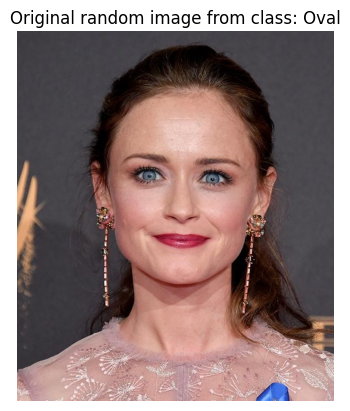

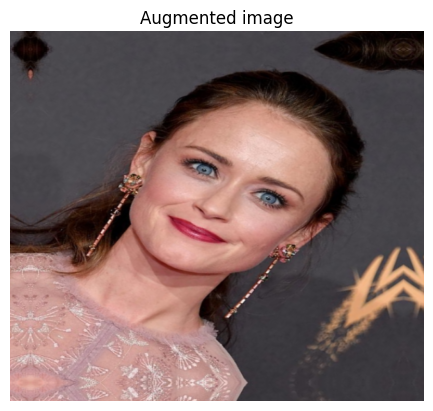

In [10]:
target_class=random.choice(train_data.class_names)

target_dir="FaceShape_Dataset/training_set/"+target_class 

random_image=random.choice(os.listdir(target_dir))

random_image_path=target_dir+"/"+random_image


# Read image 
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)


# Plot augmented random image

augmented_img=data_augmentation(img,training=True)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title("Augmented image")
plt.axis(False)

In [11]:
# Create base model with tf.keras.applications

base_model=tf.keras.applications.InceptionV3(include_top=False)

# Freeze the base model =>underlying pre-trained patterns aren't updated

base_model.trainable=True

# Create inputs into our model

# Freeze all layers except last 10 

for layer in base_model.layers[:20]:
    layer.trainable=False
    
# for layer in base_model.layers[:-10]:
#     layer.trainable=False

inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# Normalize in case of using (ResNet50v2)
x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Data augmentation layer
x= data_augmentation(inputs)


x=base_model(x)

# Average the outputs 

x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)


# Create the output activation layer

outputs = tf.keras.layers.Dense(5,activation="softmax",name="output_layer")(x)

# Combine inputs with outputs 

model_1 = tf.keras.Model(inputs,outputs)

In [12]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [13]:
# model_1_history=model_1.fit(train_data,
#                  epochs=7,
#                  steps_per_epoch=len(train_data),
#         validation_data=test_data,
#         validation_steps=len(test_data),
        #  )

In [14]:
import keras
def myModel():
    input = keras.Input(shape= (224,224,3))
    x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)
    x= data_augmentation(input)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu',)(input)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu',)(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu',)(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu',)(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1042, activation='relu',)(x)
    # x = keras.layers.Dense(4012, activation='relu',)(x)
    x = keras.layers.Dense(1042, activation='relu',)(x)
    # x = keras.layers.Dropout(0.4)(x)
    out1 = keras.layers.Dense(5, activation='softmax',name='Char1')(x)
    model = keras.models.Model(inputs=input,outputs=[out1,
                                                     
                                                     ])
    return model



model =myModel()



model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001
        ),loss='categorical_crossentropy',metrics=['accuracy'])


model_2_history=model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    epochs=8,
    validation_steps=len(test_data)
    )

Epoch 1/8
200/200 [==============================] - 35s 152ms/step - loss: 16.2123 - accuracy: 0.2266 - val_loss: 1.5952 - val_accuracy: 0.2523
Epoch 2/8
200/200 [==============================] - 29s 144ms/step - loss: 1.5963 - accuracy: 0.2672 - val_loss: 1.5908 - val_accuracy: 0.2533
Epoch 3/8
200/200 [==============================] - 29s 144ms/step - loss: 1.5387 - accuracy: 0.3202 - val_loss: 1.5998 - val_accuracy: 0.2523
Epoch 4/8
200/200 [==============================] - 30s 145ms/step - loss: 1.5130 - accuracy: 0.3395 - val_loss: 1.5794 - val_accuracy: 0.2793
Epoch 5/8
200/200 [==============================] - 29s 144ms/step - loss: 1.4760 - accuracy: 0.3696 - val_loss: 1.5695 - val_accuracy: 0.2793
Epoch 6/8
200/200 [==============================] - 29s 145ms/step - loss: 1.4466 - accuracy: 0.3846 - val_loss: 1.5635 - val_accuracy: 0.2893
Epoch 7/8
200/200 [==============================] - 29s 145ms/step - loss: 1.4166 - accuracy: 0.3983 - val_loss: 1.5494 - val_accuracy

In [17]:
model_2_history=model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    epochs=20,
    validation_steps=len(test_data)
    )

Epoch 1/20
200/200 [==============================] - 30s 145ms/step - loss: 1.2445 - accuracy: 0.4925 - val_loss: 1.5351 - val_accuracy: 0.3133
Epoch 2/20
200/200 [==============================] - 29s 145ms/step - loss: 1.1612 - accuracy: 0.5255 - val_loss: 1.5272 - val_accuracy: 0.3504
Epoch 3/20
200/200 [==============================] - 29s 144ms/step - loss: 1.0717 - accuracy: 0.5746 - val_loss: 1.5494 - val_accuracy: 0.3393
Epoch 4/20
200/200 [==============================] - 29s 145ms/step - loss: 0.9221 - accuracy: 0.6322 - val_loss: 1.5822 - val_accuracy: 0.3343
Epoch 5/20
200/200 [==============================] - 29s 145ms/step - loss: 0.7559 - accuracy: 0.7051 - val_loss: 1.6592 - val_accuracy: 0.3253
Epoch 6/20
200/200 [==============================] - 29s 145ms/step - loss: 0.6138 - accuracy: 0.7629 - val_loss: 1.7702 - val_accuracy: 0.3393
Epoch 7/20
200/200 [==============================] - 29s 145ms/step - loss: 0.5039 - accuracy: 0.8165 - val_loss: 1.8643 - val_ac

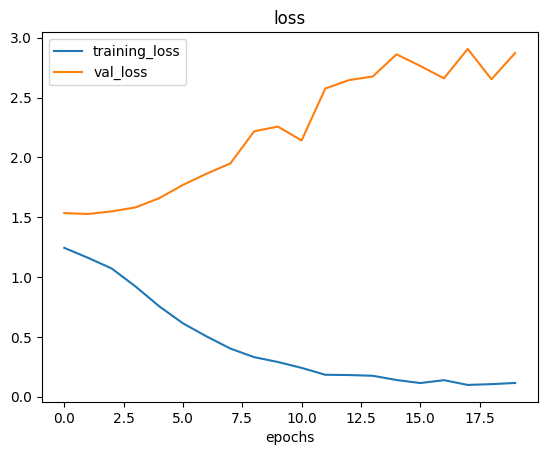

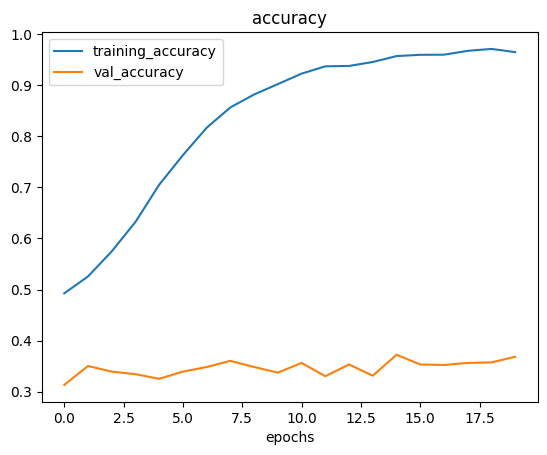

In [18]:
# plot curves 
plot_loss_curves(model_2_history)

In [ ]:
model.evaluate(test_data)

32/32 [==============================] - 4s 75ms/step - loss: 1.5596 - accuracy: 0.2893


[1.5595691204071045, 0.28928929567337036]

In [ ]:
pred_and_plot(model,"FaceShape_Dataset/testing_set/Oblong/oblong (106).jpg",224,class_names)

In [ ]:
def load_and_prep_image(filename, img_shape,scale=True):
    img=tf.io.read_file(filename)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.resize(img,size=[img_shape,img_shape])
    if scale:
        return img/255.
    else:
        return img

In [ ]:
img=load_and_prep_image("FaceShape_Dataset/testing_set/Heart/heart (365).jpg",img_shape=224)
    
pred=model.predict(tf.expand_dims(img,axis=0))
pred

array([[0.20287067, 0.19771165, 0.1981711 , 0.19961075, 0.20163582]],
      dtype=float32)

In [ ]:
class_names

array(['Heart', 'Oblong', 'Oval', 'Round', 'Square'], dtype='<U6')

In [ ]:
pred_class=class_names[np.argmax(pred)]
pred_class

'Heart'